# Taiwanese Credit Card Default Modeling.

The goal of this project to find a model which best predicts whether or not a person will default on their credit card payment. 

#### Data Set Information:

- This dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005.

- NT is the abbreviation for New Taiwan.

#### Attribute Information:

This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables: 
- X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit. 
- X2: Gender (1 = male; 2 = female). 
- X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others). 
- X4: Marital status (1 = married; 2 = single; 3 = others). 
- X5: Age (year). 
- X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: 
    - X6 = the repayment status in September, 2005; 
    - X7 = the repayment status in August, 2005; . . .;
    - etc...
    - X11 = the repayment status in April, 2005. 
    - The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
- X12-X17: Amount of bill statement (NT dollar). 
    - X12 = amount of bill statement in September, 2005;
    - etc...
    - X13 = amount of bill statement in August, 2005; . . .; 
    - X17 = amount of bill statement in April, 2005. 
- X18-X23: Amount of previous payment (NT dollar). 
    - X18 = amount paid in September, 2005; 
    - X19 = amount paid in August, 2005; . . .;
    - etc...
    - X23 = amount paid in April, 2005. 

References:

https://www.kaggle.com/stephaniestallworth/titanic-eda-classification-end-to-end

https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166

## Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, make_scorer, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV, SelectKBest, f_regression, mutual_info_regression
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
import resampling

In [3]:
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 300)

## Helper functions

In [ ]:
def heatmap_corr(dataframe):
    # Plots a heatmap of correlation between features with masking.
    fig, ax = plt.subplots(figsize=(20,20))
    mask=np.zeros_like(dataframe.corr(), dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    color_map = sns.color_palette("hot_r")
    ax = sns.heatmap(dataframe.corr(), cmap = color_map, mask=mask, square=True, annot=True)

def knnTrainTest(k_number, X_train, y_train, X_test, y_test):
    knn = KNeighborsClassifier(n_neighbors=k_number)
    # train
    knn.fit(X_train, y_train)
    # test
    y_pred_class = knn.predict(X_test)


    # check Accuracy
    print('Test Accuracy score: ', accuracy_score(y_test, y_pred_class))
    # check F1 score
    print('Test F1 score: ', f1_score(y_test, y_pred_class))
    return y_pred_class

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def logiRegr(X_train, y_train, X_test, y_test):
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    # examine coefficients
    # print(zip(X_train.columns, logreg.coef_[0]))
    # print(logreg.coef_)
    # class predictions (not predicted probabilities)
    y_pred_class = logreg.predict(X_test)
    print('Classification Accuracy: ', metrics.accuracy_score(y_test, y_pred_class))
    print('Test F1 score: ', f1_score(y_test, y_pred_class))
    # plot confusion matrix
    cm = confusion_matrix(y_test,y_pred_class)
    classes = ['DEFAULT', 'NON-default']
    plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)
    
def deciTree(X_train, y_train, X_test, y_test):
    clf = DecisionTreeClassifier() # Create Decision Tree classifer object
    clf = clf.fit(X_train,y_train) # Train Decision Tree Classifer
    y_pred_train = clf.predict(X_train) #predict the training set
    y_pred_test = clf.predict(X_test) #Predict the response for test dataset

    # Model Accuracy, how often is the classifier correct?
    print("Training F1 Score:",metrics.f1_score(y_train, y_pred_train))
    print("Testing F1 Score:",metrics.f1_score(y_test, y_pred_test))

def gridHyper(estimator, params, cv, scoring, X_train, y_train, X_test, y_test):
    gridSearch = GridSearchCV(estimator, params, cv=cv, scoring=scoring) #create the instance of GridSearchCV
    gridSearch.fit(X_train,y_train) #fit the Gridsearch to our data
    # examine the best model
    print('Training Best Score: ', gridSearch.best_score_, '\n')
    print('Training Best Params: v \n', gridSearch.best_params_, '\n\n')
    print('Training Best Estimator: v \n', gridSearch.best_estimator_, '\n\n')
    
    
    # Use the best estimator to predict the response for test dataset
    y_pred = gridSearch.best_estimator_.predict(X_test)
    # Model Accuracy, how often is the classifier correct?
    print("Testing Accuracy:", metrics.f1_score(y_test, y_pred))
    return y_pred



Median salary by education level:

1. Graduate school and above = 831496
2. University = 575575
3. Junior college = 526270
4. Senior high school = 417073
5. Junior high school = 394230
6. Primary school, Supplementary school and illiteracy = 292370

## 1. Data Cleaning

In [6]:
df = pd.read_csv('classification_lab_data.csv')

In [7]:
df.head(30)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,50000,1,2,2,49,0,0,0,0,0,0,90231,90647,92309,93880,99418,101392,2852,2784,2603,10000,3164,2868,1
1,30000,1,2,1,39,0,0,0,0,0,0,20893,22206,19273,16469,14670,11214,2007,2000,2000,417,1500,1500,0
2,260000,1,1,2,27,0,0,0,0,0,0,158711,129796,101721,76699,56738,39134,30000,4132,3410,2600,1800,1200,0
3,200000,2,2,1,33,0,0,0,0,0,0,23762,25944,26988,25237,22131,13774,4000,2000,600,3000,4000,100,0
4,50000,1,1,2,27,0,0,0,0,0,0,14614,15622,16342,17653,17697,18068,1558,1278,1589,633,656,783,0
5,150000,2,1,1,46,0,0,0,0,0,0,21787,22817,24134,24635,29032,29766,1382,1699,1200,5000,1214,1500,0
6,400000,2,2,2,41,-2,-2,-2,-2,-2,-2,43672,678,330,330,330,330,678,330,330,330,330,330,1
7,360000,2,2,2,31,0,-1,-1,-1,-2,-2,3386,5964,1340,1650,4350,4792,5964,1340,1650,4350,4792,40682,0
8,160000,2,2,2,32,2,2,2,2,-1,0,400,400,400,0,20818,20818,0,0,0,20818,0,0,0
9,500000,2,1,1,44,0,-1,-1,0,0,0,329570,71921,367979,294969,189612,128459,72001,368199,6486,234,90,167116,0


## 2. EDA

In [6]:
df.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,23999.000000,23999.000000,23999.000000,23999.000000,23999.000000,23999.000000,23999.000000,23999.000000,23999.000000,23999.000000,23999.000000,23999.000000,23999.000000,2.399900e+04,23999.000000,23999.000000,23999.000000,23999.000000,2.399900e+04,23999.000000,23999.000000,23999.000000,23999.000000,23999.000000
mean,167825.729405,1.603608,1.856786,1.550773,35.523230,-0.014959,-0.134839,-0.165632,-0.217092,-0.261344,-0.285845,51589.034710,49521.698112,4.747483e+04,43796.589775,40748.049169,39226.852411,5687.720113,6.019571e+03,5253.322805,4824.490687,4825.033793,5245.642943,0.221176
std,129915.115993,0.489158,0.791939,0.522431,9.253986,1.120903,1.193044,1.193515,1.168719,1.133016,1.150394,74104.132627,71551.215125,7.001082e+04,64927.450125,61257.537699,60075.536736,16698.506577,2.454136e+04,17967.028860,15730.753527,15596.580167,17795.775322,0.415047
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-67526.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3577.500000,2958.000000,2.718000e+03,2392.500000,1801.000000,1280.000000,1000.000000,8.585000e+02,395.000000,300.000000,269.500000,125.000000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22472.000000,21290.000000,2.022300e+04,19145.000000,18227.000000,17175.000000,2110.000000,2.012000e+03,1809.000000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,42.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67767.000000,64635.500000,6.096200e+04,55418.000000,50581.000000,49434.500000,5020.000000,5.000000e+03,4561.000000,4089.000000,4029.500000,4008.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.000000,621000.000000,426529.000000,528666.000000,1.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23999 entries, 0 to 23998
Data columns (total 24 columns):
LIMIT_BAL                     23999 non-null int64
SEX                           23999 non-null int64
EDUCATION                     23999 non-null int64
MARRIAGE                      23999 non-null int64
AGE                           23999 non-null int64
PAY_0                         23999 non-null int64
PAY_2                         23999 non-null int64
PAY_3                         23999 non-null int64
PAY_4                         23999 non-null int64
PAY_5                         23999 non-null int64
PAY_6                         23999 non-null int64
BILL_AMT1                     23999 non-null int64
BILL_AMT2                     23999 non-null int64
BILL_AMT3                     23999 non-null int64
BILL_AMT4                     23999 non-null int64
BILL_AMT5                     23999 non-null int64
BILL_AMT6                     23999 non-null int64
PAY_AMT1                

In [8]:
df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

In [9]:
df.rename({'PAY_6': 'Payment_Status_Apr', 'PAY_5': 'Payment_Status_May', 'PAY_4': 'Payment_Status_Jun', 
           'PAY_3': 'Payment_Status_Jul', 'PAY_2': 'Payment_Status_Aug', 'PAY_0': 'Payment_Status_Sep',
           'BILL_AMT6': 'Bill_Apr', 'BILL_AMT5': 'Bill_May', 'BILL_AMT4': 'Bill_Jun',
           'BILL_AMT3': 'Bill_Jul', 'BILL_AMT2': 'Bill_Aug', 'BILL_AMT1': 'Bill_Sep',
           'PAY_AMT6': 'Payments_Apr', 'PAY_AMT5': 'Payments_May', 'PAY_AMT4': 'Payments_Jun',
           'PAY_AMT3': 'Payments_Jul', 'PAY_AMT2': 'Payments_Aug', 'PAY_AMT1': 'Payments_Sep',
           'default payment next month': 'defaulted'}, axis=1, inplace=True)

In [10]:
df.loc[df['defaulted'] == 1, 'AGE'].value_counts()

27    259
29    255
25    236
24    232
28    229
30    223
26    208
36    202
31    196
23    189
34    180
32    179
35    176
37    175
33    160
39    159
42    157
38    153
41    151
40    147
22    142
44    128
46    124
43    119
47    101
45     91
49     90
48     87
50     80
51     75
52     63
53     61
55     47
56     45
54     41
58     27
57     24
61     18
60     17
59     15
21     12
66      7
63      5
62      5
64      5
73      3
69      3
67      3
68      1
72      1
70      1
75      1
Name: AGE, dtype: int64

In [11]:
df.loc[df['AGE'] > 64, 'defaulted'].value_counts()

0    67
1    20
Name: defaulted, dtype: int64

In [12]:
cols = df.drop(['SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'defaulted'], axis=1)

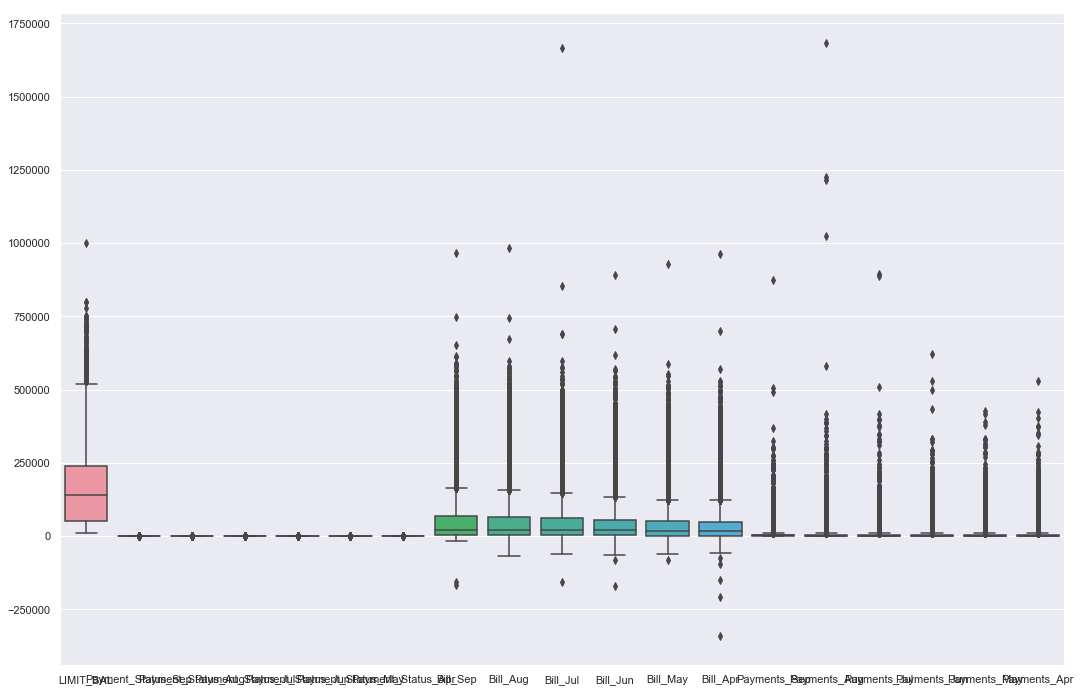

In [13]:
sns.set(rc={'figure.figsize':(18,12)})
sns.boxplot(data=cols)

## 3. Feature Engineering

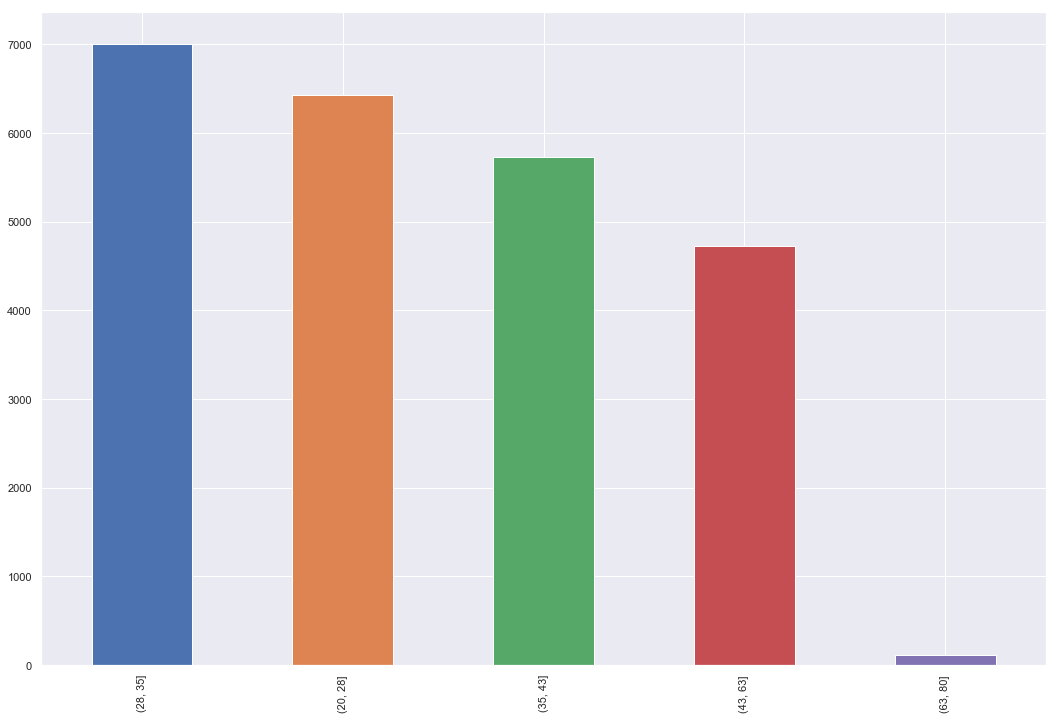

In [14]:
bins = [20, 28, 35, 43, 63, 80]
bins_age = pd.cut(df['AGE'], bins)
bins_age = bins_age.cat.as_unordered()
bins_age.value_counts().plot(kind='bar')

In [15]:
df['AGE']=bins_age

In [16]:
age_dummies = pd.get_dummies(df['AGE'], prefix="age", drop_first=True)
df = df.drop('AGE', axis=1)
df = pd.concat([df, age_dummies], axis=1)

In [17]:
marriage_dummies = pd.get_dummies(df['MARRIAGE'], prefix="marriage", drop_first=True)
df = df.drop('MARRIAGE', axis=1)
df = pd.concat([df, marriage_dummies], axis=1)
df.head()

,LIMIT_BAL,SEX,EDUCATION,Payment_Status_Sep,Payment_Status_Aug,Payment_Status_Jul,Payment_Status_Jun,Payment_Status_May,Payment_Status_Apr,Bill_Sep,Bill_Aug,Bill_Jul,Bill_Jun,Bill_May,Bill_Apr,Payments_Sep,Payments_Aug,Payments_Jul,Payments_Jun,Payments_May,Payments_Apr,defaulted,"age_(28, 35]","age_(35, 43]","age_(43, 63]","age_(63, 80]",marriage_1,marriage_2,marriage_3
0,50000,1,2,0,0,0,0,0,0,90231,90647,92309,93880,99418,101392,2852,2784,2603,10000,3164,2868,1,0,0,1,0,0,1,0
1,30000,1,2,0,0,0,0,0,0,20893,22206,19273,16469,14670,11214,2007,2000,2000,417,1500,1500,0,0,1,0,0,1,0,0
2,260000,1,1,0,0,0,0,0,0,158711,129796,101721,76699,56738,39134,30000,4132,3410,2600,1800,1200,0,0,0,0,0,0,1,0
3,200000,2,2,0,0,0,0,0,0,23762,25944,26988,25237,22131,13774,4000,2000,600,3000,4000,100,0,1,0,0,0,1,0,0
4,50000,1,1,0,0,0,0,0,0,14614,15622,16342,17653,17697,18068,1558,1278,1589,633,656,783,0,0,0,0,0,0,1,0


In [18]:
df['median_inc_edu'] = 0
df.loc[df['EDUCATION'] == 1, 'median_inc_edu'] = 831496
df.loc[df['EDUCATION'] == 2, 'median_inc_edu'] = 575575
df.loc[df['EDUCATION'] == 3, 'median_inc_edu'] = 526270
df.loc[df['EDUCATION'] == 4, 'median_inc_edu'] = 417073
df.loc[df['EDUCATION'] == 5, 'median_inc_edu'] = 394230
df.loc[df['EDUCATION'] == 6, 'median_inc_edu'] = 292370
df.loc[df['EDUCATION'] == 0, 'median_inc_edu'] = 831496


In [19]:
df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'Payment_Status_Sep',
       'Payment_Status_Aug', 'Payment_Status_Jul', 'Payment_Status_Jun',
       'Payment_Status_May', 'Payment_Status_Apr', 'Bill_Sep', 'Bill_Aug',
       'Bill_Jul', 'Bill_Jun', 'Bill_May', 'Bill_Apr', 'Payments_Sep',
       'Payments_Aug', 'Payments_Jul', 'Payments_Jun', 'Payments_May',
       'Payments_Apr', 'defaulted', 'age_(28, 35]', 'age_(35, 43]',
       'age_(43, 63]', 'age_(63, 80]', 'marriage_1', 'marriage_2',
       'marriage_3', 'median_inc_edu'],
      dtype='object')

In [20]:
columns = ['Bill_Sep','Bill_Aug','Bill_Jul', 'Bill_Jun', 'Bill_May', 'Bill_Apr',
       'Payments_Sep', 'Payments_Aug', 'Payments_Jul', 'Payments_Jun',
       'Payments_May', 'Payments_Apr']
df[columns]=df[columns].replace(0.000000,0.00000001)

In [21]:
df['Bill_Percent_Change_AprMay'] = 1 - (df['Bill_May']/df['Bill_Apr'])
df['Bill_Percent_Change_MayJun'] = 1 - (df['Bill_Jun']/df['Bill_May'])
df['Bill_Percent_Change_JunJul'] = 1 - (df['Bill_Jul']/df['Bill_Jun'])
df['Bill_Percent_Change_JulAug'] = 1 - (df['Bill_Aug']/df['Bill_Jul'])
df['Bill_Percent_Change_AugSep'] = 1 - (df['Bill_Sep']/df['Bill_Aug']) 

In [22]:
df['Bill_Percent_of_Income_Apr'] = df['Bill_Apr']/df['median_inc_edu']
df['Bill_Percent_of_Income_May'] = df['Bill_May']/df['median_inc_edu']
df['Bill_Percent_of_Income_Jun'] = df['Bill_Jun']/df['median_inc_edu']
df['Bill_Percent_of_Income_Jul'] = df['Bill_Jul']/df['median_inc_edu']
df['Bill_Percent_of_Income_Aug'] = df['Bill_Aug']/df['median_inc_edu']
df['Bill_Percent_of_Income_Sep'] = df['Bill_Sep']/df['median_inc_edu']

In [24]:
edu_dummies = pd.get_dummies(df['EDUCATION'], prefix="edu", drop_first=True)
df = df.drop('EDUCATION', axis=1)
df = pd.concat([df, edu_dummies], axis=1)
df.head()

,LIMIT_BAL,SEX,Payment_Status_Sep,Payment_Status_Aug,Payment_Status_Jul,Payment_Status_Jun,Payment_Status_May,Payment_Status_Apr,Bill_Sep,Bill_Aug,Bill_Jul,Bill_Jun,Bill_May,Bill_Apr,Payments_Sep,Payments_Aug,Payments_Jul,Payments_Jun,Payments_May,Payments_Apr,defaulted,"age_(28, 35]","age_(35, 43]","age_(43, 63]","age_(63, 80]",marriage_1,marriage_2,marriage_3,median_inc_edu,Bill_Percent_Change_AprMay,Bill_Percent_Change_MayJun,Bill_Percent_Change_JunJul,Bill_Percent_Change_JulAug,Bill_Percent_Change_AugSep,Bill_Percent_of_Income_Apr,Bill_Percent_of_Income_May,Bill_Percent_of_Income_Jun,Bill_Percent_of_Income_Jul,Bill_Percent_of_Income_Aug,Bill_Percent_of_Income_Sep,edu_1,edu_2,edu_3,edu_4,edu_5,edu_6
0,50000,1,0,0,0,0,0,0,90231.0,90647.0,92309.0,93880.0,99418.0,101392.0,2852.0,2784.0,2603.0,10000.0,3164.0,2868.0,1,0,0,1,0,0,1,0,575575,0.019469,0.055704,0.016734,0.018005,0.004589,0.176158,0.172728,0.163106,0.160377,0.157489,0.156767,0,1,0,0,0,0
1,30000,1,0,0,0,0,0,0,20893.0,22206.0,19273.0,16469.0,14670.0,11214.0,2007.0,2000.0,2000.0,417.0,1500.0,1500.0,0,0,1,0,0,1,0,0,575575,-0.308186,-0.122631,-0.170259,-0.152182,0.059128,0.019483,0.025488,0.028613,0.033485,0.038581,0.036299,0,1,0,0,0,0
2,260000,1,0,0,0,0,0,0,158711.0,129796.0,101721.0,76699.0,56738.0,39134.0,30000.0,4132.0,3410.0,2600.0,1800.0,1200.0,0,0,0,0,0,0,1,0,831496,-0.449839,-0.351810,-0.326236,-0.276000,-0.222773,0.047065,0.068236,0.092242,0.122335,0.156099,0.190874,1,0,0,0,0,0
3,200000,2,0,0,0,0,0,0,23762.0,25944.0,26988.0,25237.0,22131.0,13774.0,4000.0,2000.0,600.0,3000.0,4000.0,100.0,0,1,0,0,0,1,0,0,575575,-0.606723,-0.140346,-0.069382,0.038684,0.084104,0.023931,0.038450,0.043847,0.046889,0.045075,0.041284,0,1,0,0,0,0
4,50000,1,0,0,0,0,0,0,14614.0,15622.0,16342.0,17653.0,17697.0,18068.0,1558.0,1278.0,1589.0,633.0,656.0,783.0,0,0,0,0,0,0,1,0,831496,0.020534,0.002486,0.074265,0.044058,0.064524,0.021730,0.021283,0.021230,0.019654,0.018788,0.017576,1,0,0,0,0,0


In [25]:
df.columns

Index(['LIMIT_BAL', 'SEX', 'Payment_Status_Sep', 'Payment_Status_Aug',
       'Payment_Status_Jul', 'Payment_Status_Jun', 'Payment_Status_May',
       'Payment_Status_Apr', 'Bill_Sep', 'Bill_Aug', 'Bill_Jul', 'Bill_Jun',
       'Bill_May', 'Bill_Apr', 'Payments_Sep', 'Payments_Aug', 'Payments_Jul',
       'Payments_Jun', 'Payments_May', 'Payments_Apr', 'defaulted',
       'age_(28, 35]', 'age_(35, 43]', 'age_(43, 63]', 'age_(63, 80]',
       'marriage_1', 'marriage_2', 'marriage_3', 'median_inc_edu',
       'Bill_Percent_Change_AprMay', 'Bill_Percent_Change_MayJun',
       'Bill_Percent_Change_JunJul', 'Bill_Percent_Change_JulAug',
       'Bill_Percent_Change_AugSep', 'Bill_Percent_of_Income_Apr',
       'Bill_Percent_of_Income_May', 'Bill_Percent_of_Income_Jun',
       'Bill_Percent_of_Income_Jul', 'Bill_Percent_of_Income_Aug',
       'Bill_Percent_of_Income_Sep', 'edu_1', 'edu_2', 'edu_3', 'edu_4',
       'edu_5', 'edu_6'],
      dtype='object')

## 4. Feature Selection

In [27]:
X = df.drop('defaulted', axis = 1)
y = df['defaulted']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [40]:
scaler = StandardScaler()  
scaler.fit(X_train)

X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns) 
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  """


In [41]:
X_train_scaled.head()

,LIMIT_BAL,SEX,Payment_Status_Sep,Payment_Status_Aug,Payment_Status_Jul,Payment_Status_Jun,Payment_Status_May,Payment_Status_Apr,Bill_Sep,Bill_Aug,Bill_Jul,Bill_Jun,Bill_May,Bill_Apr,Payments_Sep,Payments_Aug,Payments_Jul,Payments_Jun,Payments_May,Payments_Apr,"age_(28, 35]","age_(35, 43]","age_(43, 63]","age_(63, 80]",marriage_1,marriage_2,marriage_3,median_inc_edu,Bill_Percent_Change_AprMay,Bill_Percent_Change_MayJun,Bill_Percent_Change_JunJul,Bill_Percent_Change_JulAug,Bill_Percent_Change_AugSep,Bill_Percent_of_Income_Apr,Bill_Percent_of_Income_May,Bill_Percent_of_Income_Jun,Bill_Percent_of_Income_Jul,Bill_Percent_of_Income_Aug,Bill_Percent_of_Income_Sep,edu_1,edu_2,edu_3,edu_4,edu_5,edu_6
0,1.023272,0.807397,0.019838,0.115263,0.138433,0.188113,0.235212,0.247958,-0.553370,-0.546433,-0.458684,-0.374572,-0.283308,-0.396107,-0.167799,-0.039862,-0.010516,-0.051997,0.005007,-0.014125,-0.645772,-0.558291,-0.492453,-0.068064,-0.909158,0.931191,-0.101629,1.315827,0.080005,0.082024,0.068841,0.072017,0.068411,-0.459348,-0.375179,-0.445646,-0.510460,-0.577962,-0.581551,1.346886,-0.933169,-0.441671,-0.063815,-0.097937,-0.043504
1,-0.755575,0.807397,0.019838,0.115263,0.138433,0.188113,2.008066,0.247958,-0.048434,0.003148,0.053088,0.165850,0.200636,0.246137,-0.199472,-0.143983,-0.034140,-0.319971,-0.167782,-0.168853,-0.645772,-0.558291,-0.492453,-0.068064,-0.909158,0.931191,-0.101629,-0.599694,0.080005,0.082024,0.068841,0.072017,0.068411,0.333096,0.281870,0.242722,0.118079,0.062830,0.006252,-0.742453,1.071618,-0.441671,-0.063815,-0.097937,-0.043504
2,2.570096,0.807397,0.019838,0.115263,0.138433,0.188113,0.235212,0.247958,0.215383,0.319203,0.240667,0.035548,0.079683,0.265180,0.022237,-0.149403,-0.233824,0.014996,3.028809,5.746997,1.548535,-0.558291,-0.492453,-0.068064,-0.909158,0.931191,-0.101629,1.315827,0.080005,0.082024,0.068841,0.072017,0.068411,0.043389,-0.100808,-0.137093,0.015410,0.067872,-0.011550,1.346886,-0.933169,-0.441671,-0.063815,-0.097937,-0.043504
3,-0.910257,0.807397,-0.875078,-0.723985,-1.536633,-1.521045,-1.537642,-1.491662,-0.668487,-0.692471,-0.675861,-0.676500,-0.665975,-0.653736,-0.357835,-0.245149,-0.305819,-0.319971,-0.303545,-0.277381,-0.645772,-0.558291,2.030650,-0.068064,1.099919,-1.073894,-0.101629,-0.968733,0.080005,0.082024,0.068841,0.072017,-0.185579,-0.655208,-0.664423,-0.672801,-0.673764,-0.686918,-0.655176,-0.742453,-0.933169,2.264128,-0.063815,-0.097937,-0.043504
4,-0.446210,0.807397,1.809671,1.793760,1.813500,1.897270,2.008066,0.247958,0.794034,0.878902,0.875262,1.073437,1.126869,1.156751,-0.020077,-0.245149,0.154854,-0.319971,-0.030292,-0.076510,1.548535,-0.558291,-0.492453,-0.068064,1.099919,-1.073894,-0.101629,-0.599694,0.080005,0.082024,0.068841,0.072017,0.068411,1.333197,1.293266,1.229148,1.011190,1.006729,0.908656,-0.742453,1.071618,-0.441671,-0.063815,-0.097937,-0.043504


## 4.1 Resampling

### Data Preping For Resampling, Separate Majority & Minority Classes

In [31]:
majority_class, minority_class = resamplingDataPrep(X_train, y_train, 'defaulted')

majority_class: 14059
minority_class: 3940


### Up-Sample Minority

In [33]:
X_train_upsampled, y_train_upsampled = upSampleMinority('defaulted', minority_class, majority_class)

1    14059
0    14059
Name: defaulted, dtype: int64


In [43]:
X_train_sm, y_train_sm = upSampleMinoritySMOTE(X_train, y_train)

28118 28118


## 5. Model Fitting
KNN, Logistic Regression, Decision Tree

### K-Nearest Neighbors

In [44]:
knnTrainTest(9, X_train_scaled, y_train_sm, X_test_scaled, y_test)

Test Accuracy score:  0.7396666666666667
Test F1 score:  0.4715832205683356


array([0, 0, 1, ..., 0, 0, 0])

### Logistic Regression

/Users/Frankie/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classification Accuracy:  0.681
Test F1 score:  0.47762008733624456
Confusion Matrix, without normalization
[[3211 1421]
 [ 493  875]]


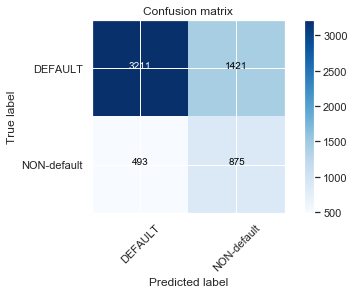

In [52]:
logiRegr(X_train_scaled, y_train_sm, X_test_scaled, y_test)

### Decision Tree

In [47]:
deciTree(X_train_sm, y_train_sm, X_test_scaled, y_test)

Training F1 Score: 0.9987181313203248
Testing F1 Score: 0.34794315632011963


# 5.1 Hyperparameter Tuning

In [52]:
# test with DecisionTree on F1 scoring
clf_tree=DecisionTreeClassifier(random_state=1)

params={'criterion': ['gini','entropy'], 
            'min_samples_leaf' : range(5,50,5),
            'max_depth': range(2,10,1)}

cv = 5
scoring = 'f1'



In [53]:
gridHyper(clf_tree, params, cv, scoring, X_train_sm, y_train_sm, X_test_scaled, y_test)

KeyboardInterrupt: 

In [76]:
clf = DecisionTreeClassifier(criterion='gini',min_samples_leaf=3,max_depth=3)
clf.fit(X_train_sm,y_train_sm)
y_pred_test = clf.predict(X_test)

In [77]:
print("Testing Accuracy:", metrics.f1_score(y_test, y_pred_test))

Testing Accuracy: 0.5080213903743316


In [261]:
selector = SelectKBest(f_regression, k=20)

selector.fit(X_train_scaled, y_train)

SelectKBest(k=20, score_func=<function f_regression at 0x1a1c60fea0>)

In [262]:
selected_columns = X_train.columns[selector.get_support()]
removed_columns = X_train.columns[~selector.get_support()]

In [263]:
list(selected_columns)

['LIMIT_BAL',
 'SEX',
 'Payment_Status_Sep',
 'Payment_Status_Aug',
 'Payment_Status_Jul',
 'Payment_Status_Jun',
 'Payment_Status_May',
 'Payment_Status_Apr',
 'Payments_Sep',
 'Payments_Aug',
 'Payments_Jul',
 'Payments_Jun',
 'Payments_May',
 'Payments_Apr',
 'age_(28, 35]',
 'median_inc_edu',
 'edu_1',
 'edu_2',
 'edu_3',
 'edu_5']

In [264]:
list(removed_columns)

['Bill_Sep',
 'Bill_Aug',
 'Bill_Jul',
 'Bill_Jun',
 'Bill_May',
 'Bill_Apr',
 'age_(35, 43]',
 'age_(43, 63]',
 'age_(63, 80]',
 'marriage_1',
 'marriage_2',
 'marriage_3',
 'Bill_Percent_Change_AprMay',
 'Bill_Percent_Change_MayJun',
 'Bill_Percent_Change_JunJul',
 'Bill_Percent_Change_JulAug',
 'Bill_Percent_Change_AugSep',
 'Bill_Percent_of_Income_Apr',
 'Bill_Percent_of_Income_May',
 'Bill_Percent_of_Income_Jun',
 'Bill_Percent_of_Income_Jul',
 'Bill_Percent_of_Income_Aug',
 'Bill_Percent_of_Income_Sep',
 'edu_4',
 'edu_6']

## 5. Model Fitting and Hyperparameter Tuning
KNN, Logistic Regression, Decision Tree

In [89]:
X = df.drop('defaulted', axis = 1)
y = df['defaulted']

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [91]:
scaler = StandardScaler()  
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)  
X_test_scaled = scaler.transform(X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  """


In [92]:
knn= KNeighborsClassifier(weights='distance')
parameters={'n_neighbors': range(1,6,2)}

In [93]:
#create the instance of GridSearchCV
grid_knn=GridSearchCV(estimator= knn, param_grid=parameters,  cv=5, scoring='f1')

#fit the Gridsearch to our data
grid_knn.fit(X_train_scaled,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': range(1, 6, 2)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='f1', verbose=0)

In [94]:
# examine the best model

# Single best score achieved across all params (min_samples_split)
print(grid_knn.best_score_)

# Dictionary containing the parameters (min_samples_split) used to generate that score
print(grid_knn.best_params_)

0.4220021206643251
{'n_neighbors': 5}


In [95]:
#Predict the response for test dataset
y_pred_knn = grid_knn.best_estimator_.predict(X_test_scaled)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.f1_score(y_test, y_pred_knn))

Accuracy: 0.4183123877917415


In [73]:
feature_cols

,LIMIT_BAL,SEX,AGE,Payment_Status_Sep,Payment_Status_Aug,Payment_Status_Jul,Payment_Status_Jun,Payment_Status_May,Payment_Status_Apr,Bill_Sep,Bill_Aug,Bill_Jul,Bill_Jun,Bill_May,Bill_Apr,Payments_Sep,Payments_Aug,Payments_Jul,Payments_Jun,Payments_May,Payments_Apr,Bill_Percent_Change_AprMay,Bill_Percent_Change_MayJun,Bill_Percent_Change_JunJul,Bill_Percent_Change_JulAug,Bill_Percent_Change_AugSep,median_inc_edu,Bill_Percent_of_Income_Apr,Bill_Percent_of_Income_May,Bill_Percent_of_Income_Jun,Bill_Percent_of_Income_Jul,Bill_Percent_of_Income_Aug,Bill_Percent_of_Income_Sep,marriage_1,marriage_2,marriage_3,edu_1,edu_2,edu_3,edu_4,edu_5,edu_6
0,50000,1,49,0,0,0,0,0,0,9.023100e+04,9.064700e+04,9.230900e+04,9.388000e+04,9.941800e+04,1.013920e+05,2.852000e+03,2.784000e+03,2.603000e+03,1.000000e+04,3.164000e+03,2.868000e+03,1.946899e-02,5.570420e-02,1.673413e-02,1.800474e-02,4.589231e-03,575575,1.761578e-01,1.727281e-01,1.631065e-01,1.603770e-01,1.574895e-01,1.567667e-01,0,1,0,0,1,0,0,0,0
1,30000,1,39,0,0,0,0,0,0,2.089300e+04,2.220600e+04,1.927300e+04,1.646900e+04,1.467000e+04,1.121400e+04,2.007000e+03,2.000000e+03,2.000000e+03,4.170000e+02,1.500000e+03,1.500000e+03,-3.081862e-01,-1.226312e-01,-1.702593e-01,-1.521818e-01,5.912816e-02,575575,1.948313e-02,2.548756e-02,2.861313e-02,3.348478e-02,3.858055e-02,3.629935e-02,1,0,0,0,1,0,0,0,0
2,260000,1,27,0,0,0,0,0,0,1.587110e+05,1.297960e+05,1.017210e+05,7.669900e+04,5.673800e+04,3.913400e+04,3.000000e+04,4.132000e+03,3.410000e+03,2.600000e+03,1.800000e+03,1.200000e+03,-4.498390e-01,-3.518101e-01,-3.262363e-01,-2.760000e-01,-2.227727e-01,831496,4.706457e-02,6.823605e-02,9.224218e-02,1.223349e-01,1.560994e-01,1.908740e-01,0,1,0,1,0,0,0,0,0
3,200000,2,33,0,0,0,0,0,0,2.376200e+04,2.594400e+04,2.698800e+04,2.523700e+04,2.213100e+04,1.377400e+04,4.000000e+03,2.000000e+03,6.000000e+02,3.000000e+03,4.000000e+03,1.000000e+02,-6.067228e-01,-1.403461e-01,-6.938226e-02,3.868386e-02,8.410422e-02,575575,2.393085e-02,3.845025e-02,4.384659e-02,4.688876e-02,4.507493e-02,4.128393e-02,1,0,0,0,1,0,0,0,0
4,50000,1,27,0,0,0,0,0,0,1.461400e+04,1.562200e+04,1.634200e+04,1.765300e+04,1.769700e+04,1.806800e+04,1.558000e+03,1.278000e+03,1.589000e+03,6.330000e+02,6.560000e+02,7.830000e+02,2.053354e-02,2.486297e-03,7.426500e-02,4.405825e-02,6.452439e-02,831496,2.172951e-02,2.128333e-02,2.123041e-02,1.965373e-02,1.878782e-02,1.757555e-02,0,1,0,1,0,0,0,0,0
5,150000,2,46,0,0,0,0,0,0,2.178700e+04,2.281700e+04,2.413400e+04,2.463500e+04,2.903200e+04,2.976600e+04,1.382000e+03,1.699000e+03,1.200000e+03,5.000000e+03,1.214000e+03,1.500000e+03,2.465901e-02,1.514536e-01,2.033692e-02,5.457032e-02,4.514178e-02,831496,3.579813e-02,3.491538e-02,2.962732e-02,2.902479e-02,2.744090e-02,2.620217e-02,1,0,0,1,0,0,0,0,0
6,400000,2,41,-2,-2,-2,-2,-2,-2,4.367200e+04,6.780000e+02,3.300000e+02,3.300000e+02,3.300000e+02,3.300000e+02,6.780000e+02,3.300000e+02,3.300000e+02,3.300000e+02,3.300000e+02,3.300000e+02,0.000000e+00,0.000000e+00,0.000000e+00,-1.054545e+00,-6.341298e+01,575575,5.733397e-04,5.733397e-04,5.733397e-04,5.733397e-04,1.177952e-03,7.587543e-02,0,1,0,0,1,0,0,0,0
7,360000,2,31,0,-1,-1,-1,-2,-2,3.386000e+03,5.964000e+03,1.340000e+03,1.650000e+03,4.350000e+03,4.792000e+03,5.964000e+03,1.340000e+03,1.650000e+03,4.350000e+03,4.792000e+03,4.068200e+04,9.223706e-02,6.206897e-01,1.878788e-01,-3.450746e+00,4.322602e-01,575575,8.325587e-03,7.557660e-03,2.866699e-03,2.328107e-03,1.036181e-02,5.882813e-03,0,1,0,0,1,0,0,0,0
8,160000,2,32,2,2,2,2,-1,0,4.000000e+02,4.000000e+02,4.000000e+02,1.000000e-08,2.081800e+04,2.081800e+04,1.000000e-08,1.000000e-08,1.000000e-08,2.081800e+04,1.000000e-08,1.000000e-08,0.000000e+00,1.000000e+00,-4.000000e+10,0.000000e+00,0.000000e+00,575575,3.616905e-02,3.616905e-02,1.737393e-14,6.949572e-04,6.949572e-04,6.949572e-04,0,1,0,0,1,0,0,0,0
9,500000,2,44,0,-1,-1,0,0,0,3.295700e+05,7.192100e+04,3.679790e+05,2.949690e+05,1.896120e+05,1.284590e+05,7.200100e+04,3.681990e+05,6.486000e+03,2.340000e+02,9.000000e+01,1.671160

In [74]:

logreg = LogisticRegression(C=1e9)
X = df.drop(['defaulted'],axis=1)
y = df.defaulted
logreg.fit(X, y)
df['defaulted'] = logreg.predict(X)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## 6. Model Evaluation

## 7. Final Model